# Data Pre-processing and processing

# Imports

In [1]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

from tqdm import tqdm
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pandas_profiling import ProfileReport
from matplotlib.animation import FuncAnimation

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

C:\Users\wangk\AppData\Local\Temp/ipykernel_15680/3596950447.py:16: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


# Setup

In [2]:
dataset_name = 'ModelNet40'
base_path = Path('../Dataset/')

# Data and Visualization

In [3]:
num_layer = 7

In [4]:
# we only use files that are existed
metadata = pd.read_csv(base_path/'metadata_modelnet40.csv')
metadata

,object_id,class,split,object_path
0,airplane_0627,airplane,test,airplane/test/airplane_0627.off
1,airplane_0628,airplane,test,airplane/test/airplane_0628.off
2,airplane_0629,airplane,test,airplane/test/airplane_0629.off
3,airplane_0630,airplane,test,airplane/test/airplane_0630.off
4,airplane_0631,airplane,test,airplane/test/airplane_0631.off
...,...,...,...,...
12306,xbox_0099,xbox,train,xbox/train/xbox_0099.off
12307,xbox_0100,xbox,train,xbox/train/xbox_0100.off
12308,xbox_0101,xbox,train,xbox/train/xbox_0101.off
12309,xbox_0102,xbox,train,xbox/train/xbox_0102.off


In [5]:
dataset_dir = base_path/f'ModelNet40-path-{num_layer}'
all_files = [f[len(str(dataset_dir))+1:].replace('\\', '/')
            for f in glob.glob(f'{dataset_dir}/*/*/*')]
# metadata_ = metadata.query('`class` in @all_labels')
metadata.object_path = metadata.object_path.\
                        str.replace('.off', '.path', regex=True)
metadata = metadata.query('`object_path` in @all_files')
# ProfileReport(metadata, minimal=True, dark_mode=True).to_notebook_iframe()

In [6]:
train_metadata = metadata.query('split == "train"')
test_metadata = metadata.query('split == "test"')

In [7]:
train_paths = [dataset_dir/fp for fp in train_metadata.object_path]
train_labels = train_metadata['class']
test_paths = [dataset_dir/fp for fp in test_metadata.object_path]
test_labels = test_metadata['class']

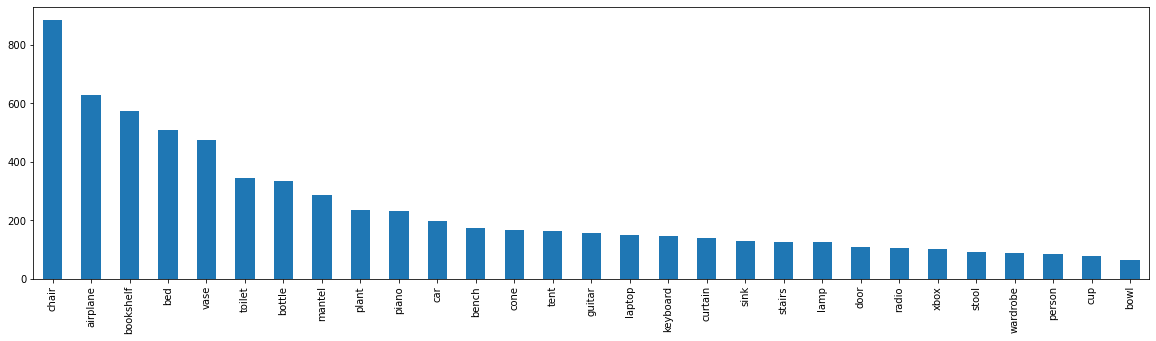

In [8]:
# plot a histogram of the number of samples per class
train_labels.value_counts().plot(kind='bar', figsize=(20, 5))
plt.show()

In [9]:
num_labels = len(set(train_labels))
num_labels

29

In [10]:
def load_path(file_path):
    path_graph = open(file_path, 'r').read().split('\n')[1:]
    num_vert, num_edge = [int(i) for i in path_graph[0].split()]
    verts = [[float(v_s) for v_s in v_str.split()] for v_str in path_graph[1:num_vert+1]]
    edges = [[int(e_s) for e_s in e_str.split()] for e_str in path_graph[num_vert+1:]][:-1]
    verts = np.array(verts)
    return verts, edges
  
file_path = metadata.object_path[0].replace('.off', '.path')
verts, edges = load_path(dataset_dir/file_path)

In [26]:
file_path = 'airplane/train/airplane_0001.path'
verts, edges = load_path(dataset_dir/file_path)


100%|██████████| 11690/11690 [00:10<00:00, 1090.30it/s]


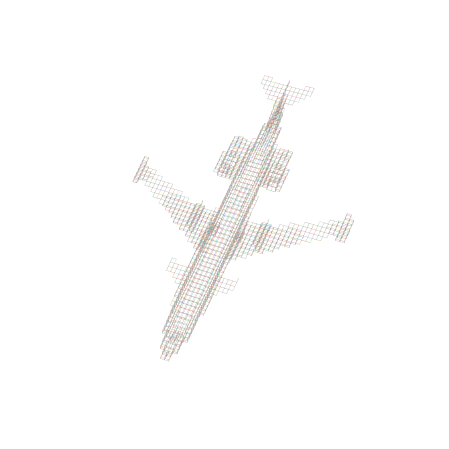

In [11]:
def visualize(verts, edges):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    for edge in tqdm(edges):
        ax.plot(
            [verts[edge[0], 0], verts[edge[1], 0]],
            [verts[edge[0], 1], verts[edge[1], 1]],
            [verts[edge[0], 2], verts[edge[1], 2]],
            linewidth=0.1,
        )
    ax.axis('off')
    plt.show()

visualize(verts, edges)

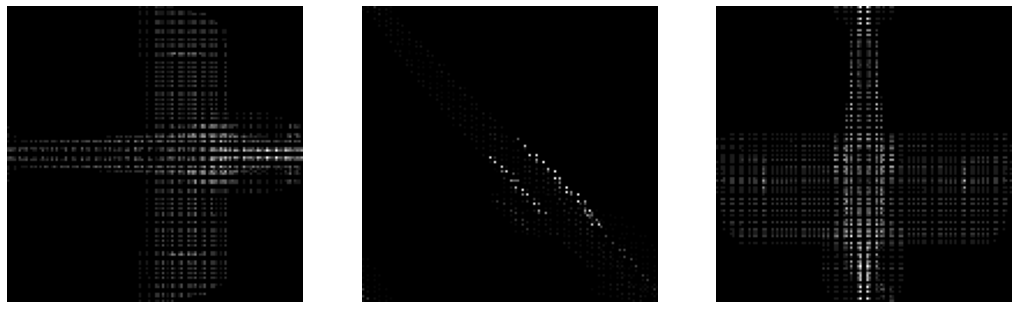

In [28]:
def visualize_bitmap(ax, bitmap):
    ax.imshow(bitmap, cmap='gray')
    ax.axis('off')



def get_bitmap(verts, axis, precision):
    verts_= (np.round(verts, 2)*2**precision).astype( 'int')
    bitmap = np.zeros((2**precision,2**precision))
    for i,j in verts_[:,axis].clip(-2**precision, 2**precision-1):
        bitmap[min(i, 2**precision-1),
               min(j, 2**precision-1)] += 1
    return bitmap / np.max(bitmap)

def get_bitmaps(verts, edges, precision=7):
    bm1 = get_bitmap(verts, [0,1], precision=precision).tolist()
    bm2 = get_bitmap(verts, [1,2], precision=precision).tolist()
    bm3 = get_bitmap(verts, [2,0], precision=precision).tolist()
    return [bm1, bm2, bm3]

bitmaps = get_bitmaps(verts, edges)

fig, ax = plt.subplots(1,3, figsize=(18,6))
visualize_bitmap(ax[0], bitmaps[0])
visualize_bitmap(ax[1], bitmaps[1])
visualize_bitmap(ax[2], bitmaps[2])
plt.show()


In [29]:
# convert data to bitmaps
train_data = [get_bitmaps(*load_path(fp)) for fp in tqdm(train_paths)]
os.makedirs('../SavedData', exist_ok=True)
with open(f'../SavedData/train_dataset-{num_layer}.pkl', 'wb') as f:
   pickle.dump((train_data, train_labels.tolist()), f)

In [30]:
test_data = [get_bitmaps(*load_path(fp)) for fp in tqdm(test_paths)]
with open(f'../SavedData/test_dataset-{num_layer}.pkl', 'wb') as f:
   pickle.dump((test_data, test_labels.tolist()), f)

100%|██████████| 1536/1536 [06:25<00:00,  3.99it/s]
